#### Imports

In [1]:
from pylab import zeros, arange, subplots, plt, savefig
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.backends.cudnn as cudnn
import torchvision.models as models
from PIL import Image
import numpy as np
import logging
import torch
import time

#### Setup logger

In [2]:
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)
logger.addHandler(logging.StreamHandler())

In [3]:
logger.info(f'Using torch: {torch.__version__}')

Using torch: 1.4.0


#### Essentials

In [4]:
DATASET_ROOT = './data/'
CAPTIONS_TRAIN_SET_PATH = 'embedding/caption_embedding.csv'
CAPTIONS_VALIDATION_SET_PATH = 'embedding/caption_embedding.csv'

In [5]:
EMBEDDING_DIMENSIONALITY = 1000 # number of CNN outputs = dimensionality of the captions word2vec model
BATCH_SIZE = 4 
EPOCHS = 10
WORKERS = 4 # number of data loading workers = CPU cores
GPU = 0
LR = 0.01 
MOMENTUM = 0.9
WEIGHT_DECAY = 1e-4

In [6]:
cudnn.benchmark = True

#### Define model

In [7]:
class Model(torch.nn.Module):
    def __init__(self, embedding_dimensionality):
        super(Model, self).__init__()
        self.cnn = models.resnet50(pretrained=True, num_classes=embedding_dimensionality)

    def forward(self, image):
        x = self.cnn(image)
        return x

https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html

In [8]:
criterion = torch.nn.BCEWithLogitsLoss().cuda(GPU)

Create ResNet50 model with custom number of outputs

In [9]:
model = Model(embedding_dimensionality=EMBEDDING_DIMENSIONALITY).cuda(GPU)

In [10]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0.0001
)

In [11]:
model = torch.nn.DataParallel(model, device_ids=[GPU])

#### Define and load datasets

In [12]:
class Dataset(Dataset):
    def __init__(self, root_dir, split, embedding_dimensionality):
        self.root_dir = root_dir
        self.split = split
        self.embedding_dimensionality = embedding_dimensionality
        self.preprocess = transforms.Compose([transforms.RandomHorizontalFlip(), 
                                              transforms.RandomCrop(224), 
                                              transforms.ToTensor(), 
                                              transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                                   std=[0.229, 0.224, 0.225])])
        logger.info(f'Loading data from {split}')
        
        # count number of images in the split
        n = 0
        with open(f'{DATASET_ROOT}{CAPTIONS_TRAIN_SET_PATH}', 'r') as f:
            for _, _ in enumerate(f):
                n += 1
                
        # placeholder for image ids - dummy bytes
        self.img_ids = np.empty([n], dtype='S50')
        # placeholder for captions embedding - [number of captions * vector dimension]
        self.captions_embeddings = np.zeros((n, self.embedding_dimensionality), dtype=np.float32)
        
        # populate the placeholders 
        with open(f'{DATASET_ROOT}{CAPTIONS_TRAIN_SET_PATH}', 'r') as f:
            for idx, row in enumerate(f):
                uid, vec = row.split('\t')
                vec = vec.strip().split(',')
                self.img_ids[idx] = uid
                for i in range(self.embedding_dimensionality):
                    self.captions_embeddings[idx, i] = float(vec[i])
        logger.info(f'Caption embedding shape = {self.captions_embeddings[0].shape}')
        logger.info('Data loading done.')

    def __len__(self):
        return len(self.img_ids)
    
    def __getitem__(self, idx):
        img_id = self.img_ids[idx].decode('utf-8')
        img = Image.open(f'{DATASET_ROOT}images/{img_id}.jpg').convert('RGB')
        img_tensor = self.preprocess(img)
        target_tensor = torch.from_numpy(self.captions_embeddings[idx, :])
        return img_id, img_tensor, target_tensor

In [13]:
train_dataset = Dataset(DATASET_ROOT, CAPTIONS_TRAIN_SET_PATH, EMBEDDING_DIMENSIONALITY)

Loading data from embedding/caption_embedding.csv
Caption embedding shape = (1000,)
Data loading done.


In [14]:
len(train_dataset)

20

Dataset object wraps - image id, image tensor and the caption embedding tensor.

In [15]:
image_id, image_tensor, caption_embedding_tensor = train_dataset[3]

In [16]:
image_id

'1489658491986857252'

In [17]:
image_tensor.shape

torch.Size([3, 224, 224])

In [18]:
caption_embedding_tensor.shape

torch.Size([1000])

In [19]:
val_dataset = Dataset(DATASET_ROOT, CAPTIONS_VALIDATION_SET_PATH, EMBEDDING_DIMENSIONALITY)

Loading data from embedding/caption_embedding.csv
Caption embedding shape = (1000,)
Data loading done.


`pin_memory` allows better transferring of samples to GPU memory

In [20]:
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True, 
                                           num_workers=WORKERS, 
                                           pin_memory=True)

In [21]:
train_loader.__dict__

{'dataset': <__main__.Dataset at 0x7f7bd26880b8>,
 'num_workers': 4,
 'pin_memory': True,
 'timeout': 0,
 'worker_init_fn': None,
 '_DataLoader__multiprocessing_context': None,
 '_dataset_kind': 0,
 'batch_size': 4,
 'drop_last': False,
 'sampler': <torch.utils.data.sampler.RandomSampler at 0x7f7bd7732b38>,
 'batch_sampler': <torch.utils.data.sampler.BatchSampler at 0x7f7bd7732b70>,
 'collate_fn': <function torch.utils.data._utils.collate.default_collate(batch)>,
 '_DataLoader__initialized': True,
 '_IterableDataset_len_called': None}

In [22]:
val_loader = torch.utils.data.DataLoader(val_dataset, 
                                         batch_size=BATCH_SIZE, 
                                         shuffle=True, 
                                         num_workers=WORKERS, 
                                         pin_memory=True)

#### Monitor

In [23]:
class AverageMeter(object):
    """
    Computes and stores the average and current value.
    """
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

#### Train

In [24]:
print_freq = 1 # how frequently to print loss value to screen

In [25]:
def train(train_loader, model, criterion, optimizer, epoch, print_freq, plot_data, gpu):
    batch_time = AverageMeter()
    loss_meter = AverageMeter()

    model.train()
    
    end = time.time()
    for i, (img_id, image, target) in enumerate(train_loader):
        target_var = torch.autograd.Variable(target).cuda(GPU)
        image_var = torch.autograd.Variable(image)

        # compute output
        output = model(image_var)
        loss = criterion(output, target_var)
        
        # measure and record loss
        # loss.data.item() => loss value
        # image.size()[0] => batch size
        loss_meter.update(loss.data.item(), image.size()[0])

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        
        if i % print_freq == 0:
            logger.info(f'Epoch: [{epoch}] | Train Batch: [{i}/{len(train_loader)}]')
            logger.info(f'Train Loss: [loss.val={loss_meter.val}] [loss.avg={loss_meter.avg}]')
            logger.info(f'Train Batch Time: [{batch_time.avg}]')
            
    plot_data['train_loss'][plot_data['epoch']] = loss_meter.avg
    
    return plot_data

In [26]:
def validate(val_loader, model, criterion, print_freq, plot_data, gpu):
    with torch.no_grad():
        batch_time = AverageMeter()
        loss_meter = AverageMeter()

        # switch to evaluate mode
        model.eval()

        end = time.time()
        for i, (img_id, image, target) in enumerate(val_loader):
            target_var = torch.autograd.Variable(target).cuda(GPU)
            image_var = torch.autograd.Variable(image)

            # compute output
            output = model(image_var)
            loss = criterion(output, target_var)

            # measure and record loss
            loss_meter.update(loss.data.item(), image.size()[0])

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()
            
            if i % print_freq == 0:
                logger.info(f'Val Batch: [{i}/{len(val_loader)}]')
                logger.info(f'Val Loss: [loss.val={loss_meter.val}] [loss.avg={loss_meter.avg}]')
                logger.info(f'Val Batch Time: [{batch_time.avg}]')
        plot_data['val_loss'][plot_data['epoch']] = loss_meter.avg

    return plot_data

In [27]:
def save_checkpoint(model, filename):
    logger.info('Saving model checkpoint')
    torch.save(model.state_dict(), filename + '.pth.tar')

Epoch: [0] | Train Batch: [0/5]
Train Loss: [loss.val=0.9345870018005371] [loss.avg=0.9345870018005371]
Train Batch Time: [5.205448865890503]
Epoch: [0] | Train Batch: [1/5]
Train Loss: [loss.val=2.281630039215088] [loss.avg=1.6081085205078125]
Train Batch Time: [2.667778730392456]
Epoch: [0] | Train Batch: [2/5]
Train Loss: [loss.val=1.2691166400909424] [loss.avg=1.4951112270355225]
Train Batch Time: [1.825080156326294]
Epoch: [0] | Train Batch: [3/5]
Train Loss: [loss.val=0.8656741380691528] [loss.avg=1.33775195479393]
Train Batch Time: [1.4036982655525208]
Epoch: [0] | Train Batch: [4/5]
Train Loss: [loss.val=0.8268405199050903] [loss.avg=1.235569667816162]
Train Batch Time: [1.1508888244628905]
Val Batch: [0/5]
Val Loss: [loss.val=6427056275456.0] [loss.avg=6427056275456.0]
Val Batch Time: [0.13634896278381348]
Val Batch: [1/5]
Val Loss: [loss.val=11987515867136.0] [loss.avg=9207286071296.0]
Val Batch Time: [0.0874629020690918]
Val Batch: [2/5]
Val Loss: [loss.val=3799683956736.0] 

Train Batch Time: [0.18706262111663818]
Epoch: [6] | Train Batch: [2/5]
Train Loss: [loss.val=0.6826593279838562] [loss.avg=0.6870079437891642]
Train Batch Time: [0.17125733693440756]
Epoch: [6] | Train Batch: [3/5]
Train Loss: [loss.val=0.6578279137611389] [loss.avg=0.6797129362821579]
Train Batch Time: [0.1633630394935608]
Epoch: [6] | Train Batch: [4/5]
Train Loss: [loss.val=0.6891739964485168] [loss.avg=0.6816051483154297]
Train Batch Time: [0.15855112075805664]
Val Batch: [0/5]
Val Loss: [loss.val=5.606411457061768] [loss.avg=5.606411457061768]
Val Batch Time: [0.14147067070007324]
Val Batch: [1/5]
Val Loss: [loss.val=0.9032280445098877] [loss.avg=3.2548197507858276]
Val Batch Time: [0.09042763710021973]
Val Batch: [2/5]
Val Loss: [loss.val=3.813492774963379] [loss.avg=3.4410440921783447]
Val Batch Time: [0.0728610356648763]
Val Batch: [3/5]
Val Loss: [loss.val=4.088891506195068] [loss.avg=3.6030059456825256]
Val Batch Time: [0.06419903039932251]
Val Batch: [4/5]
Val Loss: [loss.v

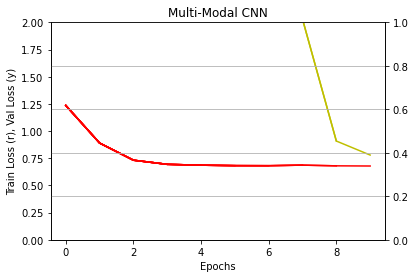

In [28]:
plot_data = {}
plot_data['train_loss'] = zeros(EPOCHS)
plot_data['val_loss'] = zeros(EPOCHS)
plot_data['epoch'] = 0

it_axes = arange(EPOCHS)
_, ax1 = subplots()
ax2 = ax1.twinx()
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Train Loss (r), Val Loss (y)')
ax1.set_ylim([0, 2])
best_loss = 1000


for epoch in range(EPOCHS):
    plot_data['epoch'] = epoch
    # train for one epoch
    plot_data = train(train_loader, model, criterion, optimizer, epoch, print_freq, plot_data, GPU)
    # evaluate on validation set
    plot_data = validate(val_loader, model, criterion, print_freq, plot_data, GPU)
    
    # remember best model and save checkpoint
    is_best = plot_data['val_loss'][epoch] < best_loss
    if is_best:
        val_loss = plot_data['val_loss'][epoch]
        logger.info(f'New best model by [Val Loss = {val_loss}]')
        best_loss = plot_data['val_loss'][epoch]
        filename = f'{DATASET_ROOT}/models/multi-modal-epoch-{epoch}'
        save_checkpoint(model, filename)
    
    ax1.plot(it_axes[0: epoch+1], plot_data['train_loss'][0: epoch+1], 'r')
    ax1.plot(it_axes[0: epoch+1], plot_data['val_loss'][0: epoch+1], 'y')
    plt.grid(True)
    plt.title('Multi-Modal CNN')
    
    # save plot to disk
    title = f'{DATASET_ROOT}plots/epoch_{epoch}.jpg'
    savefig(title, bbox_inches='tight')